# 사이킷런을 활용한 추천 시스템 입문

콘텐츠 기반 필터링(Content Based Filtering)
해당 예제는 CODE HEROKU의 'Building a Movie Recemmendation Engine in Python using Scikit-Learn' 을 바탕으로 제작되었습니다.

$ mkdir -p ~/aiffel/movie_recommendation

In [1]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics.pairwise import cosine_similarity

print('⏩⏩')

⏩⏩


예제 데이터는 movie_dataset을 사용하도록 하겠습니다. 다음 데이터를 다운로드 받은 뒤 ~/aiffel/movie_recommendation 디렉토리 내에 저장합니다. 파일: movie_dataset

In [2]:
import os
csv_path = os.getenv('HOME')+'/aiffel/movie_recommendation/movie_dataset.csv'
df = pd.read_csv(csv_path)
df.head()

,index,budget,genres,homepage,id,keywords,original_language,original_title,overview,popularity,...,runtime,spoken_languages,status,tagline,title,vote_average,vote_count,cast,crew,director
0,0,237000000,Action Adventure Fantasy Science Fiction,http://www.avatarmovie.com/,19995,culture clash future space war space colony so...,en,Avatar,"In the 22nd century, a paraplegic Marine is di...",150.437577,...,162.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}, {""iso...",Released,Enter the World of Pandora.,Avatar,7.2,11800,Sam Worthington Zoe Saldana Sigourney Weaver S...,"[{'name': 'Stephen E. Rivkin', 'gender': 0, 'd...",James Cameron
1,1,300000000,Adventure Fantasy Action,http://disney.go.com/disneypictures/pirates/,285,ocean drug abuse exotic island east india trad...,en,Pirates of the Caribbean: At World's End,"Captain Barbossa, long believed to be dead, ha...",139.082615,...,169.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"At the end of the world, the adventure begins.",Pirates of the Caribbean: At World's End,6.9,4500,Johnny Depp Orlando Bloom Keira Knightley Stel...,"[{'name': 'Dariusz Wolski', 'gender': 2, 'depa...",Gore Verbinski
2,2,245000000,Action Adventure Crime,http://www.sonypictures.com/movies/spectre/,206647,spy based on novel secret agent sequel mi6,en,Spectre,A cryptic message from Bond’s past sends him o...,107.376788,...,148.0,"[{""iso_639_1"": ""fr"", ""name"": ""Fran\u00e7ais""},...",Released,A Plan No One Escapes,Spectre,6.3,4466,Daniel Craig Christoph Waltz L\u00e9a Seydoux ...,"[{'name': 'Thomas Newman', 'gender': 2, 'depar...",Sam Mendes
3,3,250000000,Action Crime Drama Thriller,http://www.thedarkknightrises.com/,49026,dc comics crime fighter terrorist secret ident...,en,The Dark Knight Rises,Following the death of District Attorney Harve...,112.312950,...,165.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,The Legend Ends,The Dark Knight Rises,7.6,9106,Christian Bale Michael Caine Gary Oldman Anne ...,"[{'name': 'Hans Zimmer', 'gender': 2, 'departm...",Christopher Nolan
4,4,260000000,Action Adventure Science Fiction,http://movies.disney.com/john-carter,49529,based on novel mars medallion space travel pri...,en,John Carter,"John Carter is a war-weary, former military ca...",43.926995,...,132.0,"[{""iso_639_1"": ""en"", ""name"": ""English""}]",Released,"Lost in our world, found in another.",John Carter,6.1,2124,Taylor Kitsch Lynn Collins Samantha Morton Wil...,"[{'name': 'Andrew Stanton', 'gender': 2, 'depa...",Andrew Stanton


In [3]:
df.columns

Index(['index', 'budget', 'genres', 'homepage', 'id', 'keywords',
       'original_language', 'original_title', 'overview', 'popularity',
       'production_companies', 'production_countries', 'release_date',
       'revenue', 'runtime', 'spoken_languages', 'status', 'tagline', 'title',
       'vote_average', 'vote_count', 'cast', 'crew', 'director'],
      dtype='object')

데이터의 칼럼들이 꽤 많습니다. 이 각각의 칼럼을 특성으로 볼 수 있지만, 여기서는 다음과 같은 특성만 고려하여 영화의 유사도를 계산하여 추천하도록 하겠습니다.

In [4]:
features = ['keywords','cast','genres','director']
features

['keywords', 'cast', 'genres', 'director']

In [5]:
def combine_features(row):
    return row['keywords']+" "+row['cast']+" "+row['genres']+" "+row['director']

combine_features(df[:5])

0    culture clash future space war space colony so...
1    ocean drug abuse exotic island east india trad...
2    spy based on novel secret agent sequel mi6 Dan...
3    dc comics crime fighter terrorist secret ident...
4    based on novel mars medallion space travel pri...
dtype: object

In [6]:
for feature in features:
    df[feature] = df[feature].fillna('')

df["combined_features"] = df.apply(combine_features,axis=1)
df["combined_features"]

0       culture clash future space war space colony so...
1       ocean drug abuse exotic island east india trad...
2       spy based on novel secret agent sequel mi6 Dan...
3       dc comics crime fighter terrorist secret ident...
4       based on novel mars medallion space travel pri...
                              ...                        
4798    united states\u2013mexico barrier legs arms pa...
4799     Edward Burns Kerry Bish\u00e9 Marsha Dietlein...
4800    date love at first sight narration investigati...
4801     Daniel Henney Eliza Coupe Bill Paxton Alan Ru...
4802    obsession camcorder crush dream girl Drew Barr...
Name: combined_features, Length: 4803, dtype: object

여기서는 간단하게 보기 위해 해당 특성을 텍스트 데이터로 보고, 보고자 하는 특성으로 이루어진 텍스트 데이터를 새로운 칼럼으로 생성하였습니다.

이제 이 칼럼을 벡터화하고, 코사인 유사도를 계산해보겠습니다. 장르, 배우명, 감독명의 텍스트 데이터를 범주형 데이터로 보기 때문에 단순하게 등장횟수를 세어 숫자 벡터로 만들겠습니다. 사이킷런의 CountVectorizer()를 사용하면 편하게 하실 수 있습니다.

In [7]:
cv = CountVectorizer()
count_matrix = cv.fit_transform(df["combined_features"])
print(type(count_matrix))
print(count_matrix.shape)
print(count_matrix)

<class 'scipy.sparse.csr.csr_matrix'>
(4803, 14845)
  (0, 3115)	1
  (0, 2616)	1
  (0, 4886)	1
  (0, 12386)	2
  (0, 14235)	1
  (0, 2755)	1
  (0, 12299)	1
  (0, 11517)	1
  (0, 14561)	1
  (0, 14820)	1
  (0, 11490)	1
  (0, 12134)	1
  (0, 14291)	1
  (0, 12567)	1
  (0, 7496)	1
  (0, 8831)	1
  (0, 11217)	1
  (0, 86)	1
  (0, 144)	1
  (0, 4435)	1
  (0, 11745)	1
  (0, 4566)	1
  (0, 6542)	1
  (0, 2061)	1
  (1, 86)	1
  :	:
  (4801, 10069)	1
  (4801, 5844)	1
  (4801, 252)	1
  (4801, 4098)	1
  (4801, 14796)	1
  (4801, 11361)	1
  (4801, 2978)	1
  (4801, 12036)	1
  (4801, 6138)	1
  (4802, 9659)	1
  (4802, 3812)	1
  (4802, 1788)	2
  (4802, 4210)	1
  (4802, 5181)	1
  (4802, 2912)	1
  (4802, 3821)	1
  (4802, 1069)	1
  (4802, 11185)	1
  (4802, 3681)	1
  (4802, 5399)	1
  (4802, 3894)	1
  (4802, 2056)	1
  (4802, 3093)	1
  (4802, 4502)	1
  (4802, 5900)	2


count_matrix는 type을 확인해 본 결과, CSR(Compressed Sparse Row) Matrix였습니다. CSR Matrix는 Sparse한 matrix에서 0이 아닌 유효한 데이터로 채워지는 데이터의 값과 좌표 정보로만으로 구성하여 메모리 사용량을 최소화하면서도 Sparse한 matrix와 동일한 행렬을 표현할 수 있도록 하는 데이터 구조입니다.

예를 들어, (0, 3115) 1라고 되어 있는 것은 1번째 row는 3116번째 단어가 1번 출현한다는 뜻입니다. 이 데이터셋에는 총 14845개의 단어가 존재하는데, 이 단어들을 범주형으로 보고 그 단어의 출현 빈도만을 표시한 Matrix가 매우 Sparse하기 때문에 공간을 절약할 수 있는 형태로 표현한 것입니다.

이제 4803개의 영화들이 모두 Vectorized되었습니다. 이 영화들끼리의 코사인 유사도를 표현하는 4803X4803 의 cosine_similarity matrix를 구해 봅시다.

In [8]:
cosine_sim = cosine_similarity(count_matrix)
print(cosine_sim)
print(cosine_sim.shape)

[[1.         0.10540926 0.12038585 ... 0.         0.         0.        ]
 [0.10540926 1.         0.0761387  ... 0.03651484 0.         0.        ]
 [0.12038585 0.0761387  1.         ... 0.         0.11145564 0.        ]
 ...
 [0.         0.03651484 0.         ... 1.         0.         0.04264014]
 [0.         0.         0.11145564 ... 0.         1.         0.        ]
 [0.         0.         0.         ... 0.04264014 0.         1.        ]]
(4803, 4803)


코사인 유사도로 계산된 가장 비슷한 영화를 3편을 선별하여 추천해 보겠습니다.

In [9]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]
def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

movie_user_likes = "Avatar"
movie_index = get_index_from_title(movie_user_likes)
similar_movies = list(enumerate(cosine_sim[movie_index]))

sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]

i=0
print(movie_user_likes+"와 비슷한 영화 3편은 "+"\n")
for item in sorted_similar_movies:
    print(get_title_from_index(item[0]))
    i=i+1
    if i==3:
        break

Avatar와 비슷한 영화 3편은 

Guardians of the Galaxy
Aliens
Star Wars: Clone Wars: Volume 1


아바타(Avatar)와 유사한 영화 3편은 가디언즈 오브 갤럭시, 에어리언, 스타워즈로 나왔습니다.

Q. 'Titanic' 과 유사한 영화 5편은 무엇일까요? 위 코드를 활용해서 맞춰보세요.

In [11]:
def get_title_from_index(index):
    return df[df.index == index]["title"].values[0]
def get_index_from_title(title):
    return df[df.title == title]["index"].values[0]

movie_user_likes = "Titanic"
movie_index = get_index_from_title(movie_user_likes)
similar_movies = list(enumerate(cosine_sim[movie_index]))

sorted_similar_movies = sorted(similar_movies,key=lambda x:x[1],reverse=True)[1:]

i=0
print(movie_user_likes+"와 비슷한 영화 5편은 "+"\n")
for item in sorted_similar_movies:
    print(get_title_from_index(item[0]))
    i=i+1
    if i==5:
        break

Titanic와 비슷한 영화 5편은 

Revolutionary Road
Me You and Five Bucks
All the King's Men
The Day the Earth Stood Still
Almost Famous


협업 필터링 (1) 협업 필터링의 종류

협업 필터링(Collaborative Filtering) 은 과거의 사용자 행동 양식(User Behavior) 데이터를 기반으로 추천하는 방식입니다. 여기서 다루는 학습용 데이터 자체에서 사용자 행동양식을 나타내기 어렵지만, 잠재요인 기법을 활용하면 행동양식을 어느 정도 데이터로 나타낼 수 있습니다.

우선은 협업 필터링의 기본 원리를 살펴봅시다. 영화 추천을 예시로 들어보겠습니다. 아래 표를 살펴볼까요. 사용자들의 정보는 user_id에 저장되어 있습니다. 그리고 영화 정보는 item_id입니다. 사용자는 영화를 보고 평점 (rating)을 매겼습니다. 그 평점을 매긴 시각이 timestamp 칼럼에 기록되어있습니다.



In [13]:
import os
print(os.getcwd())  # 현재 작업 디렉토리


/aiffel/aiffel


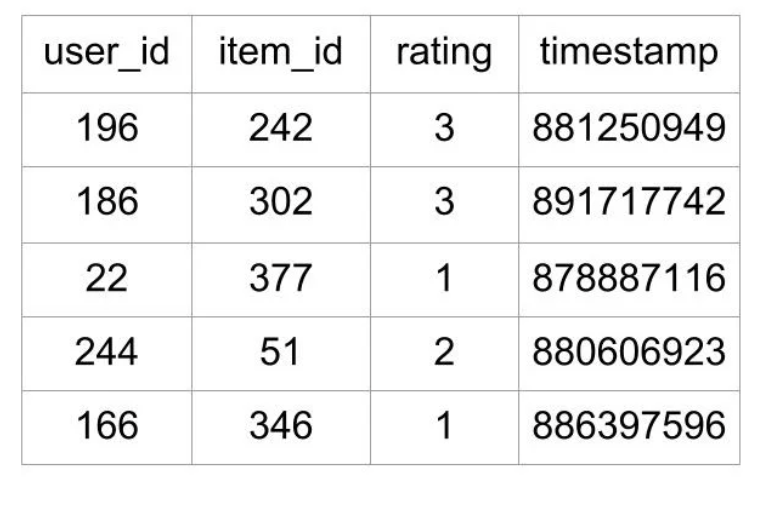

In [16]:
from IPython.display import Image, display

# 이미지 파일 경로
image_path = "/aiffel/aiffel/movie_recommendation/movie_data.max-800x600.png"

# 이미지를 노트북에서 표시 (크기를 절반으로 조정)
display(Image(filename=image_path, width=400, height=300))


위 데이터를 사용자와 아이템 간 interaction matrix로 변환합니다. 
해당 행렬의 데이터로 평점을 넣으면 아래와 같은 형태가 되겠죠? 우리는 이를 평점행렬이라고 부르기도 합니다.

이러한 행렬을 실제 데이터로 만든다면 굉장히 희소(sparse)한 행렬이 만들어집니다. 
유튜브나 넷플릭스에는 몇 억 개의 동영상이 있고, 몇 억 명의 사용자가 모든 동영상을 다 봤을리 만무합니다. 
따라서 대부분 평점에 대한 데이터는 0입니다.

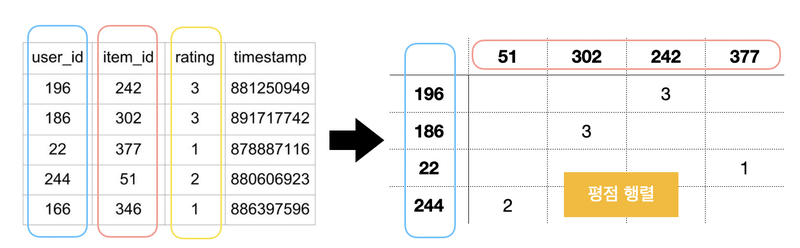

In [15]:
from IPython.display import Image, display

# 이미지 파일 경로
image_path = "/aiffel/aiffel/movie_recommendation/interaction_matrix.max-800x600.png"

# 이미지를 노트북에서 표시
display(Image(filename=image_path))

협업 필터링의 종류에는 크게 사용자 기반, 아이템 기반 그리고 잠재요인(latent factor) 방식이 있습니다. 사용자 기반과 아이템 기반은 유사도를 계산하는 방식이고 잠재요인은 행렬 인수분해(matrix factorization)를 이용해 잠재요인을 분석합니다. 
넷플릭스의 추천 시스템에 잠재요인 분석을 사용하여 최근에는 잠재요인을 분석하는 사례가 많아지고 있는 추세입니다. 즉, 위에서 설명한 평점행렬로 변환한 후, 평점행렬의 유사도를 계산하여 추천하는 방식은 사용자 기반과 아이템 기반 방식입니다. 그리고 이 평점행렬을 분해하여 더 많은 정보들을 고려하는 방식이 잠재요인 필터링입니다.

1. 사용자 기반
협업 필터링은 다시 사용자 기반과 아이템 기반으로 나뉜다고 했습니다. 이 방식은 동일한 제품에 대해 평점을 매긴 데이터를 분석하여 추천을 하는 방식입니다. 사용자 기반 협업 필터링은 아래와 같은 문구로 요약할 수 있죠.

당신과 비슷한 고객들이 다음 상품을 구매했습니다.

사용자와 아이템 간의 평점행렬이 있습니다. User4가 item1을 구매하였습니다. 그리고 User4와 가장 유사한 User2는 item1 ~ 4까지 다음과 같이 평점을 매겼습니다. 그러면 어떤 제품을 추천해 주면 좋을까요?.
아래처럼 User2가 선호한 제품인 item3을 User4에게 추천해 주는 방식입니다.

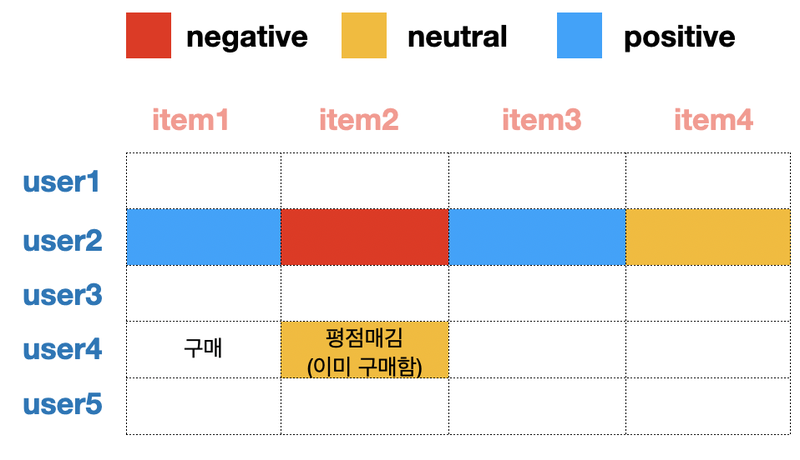

In [17]:
from IPython.display import Image, display

# 이미지 파일 경로
image_path = "/aiffel/aiffel/movie_recommendation/user.max-800x600.png"

# 이미지를 노트북에서 표시 (크기를 절반으로 조정)
display(Image(filename=image_path, width=400, height=300))

2. 아이템 기반
아이템 기반은 아이템 간의 유사도를 측정하여 해당 아이템을 추천하는 방식입니다. 일반적으로 사용자 기반보다는 아이템 기반 방식이 정확도가 더 높다고 합니다. 아이템 기반 협업 필터링은 아래와 같은 문구로 요약할 수 있습니다.

이 상품을 선택한 다른 고객들은 다음 상품을 구매했습니다.

이 방식은 다음과 같은 순서로 진행됩니다. User2가 선호하는 아이템이 있습니다. 그 아이템은 item1이네요. 그 아이템에 대한 다른 User들의 선호도를 조사합니다. item1을 좋아한 사람은 user4입니다. 그 user4에게 user2가 좋아한 상품인 item3을 추천해 줍니다.

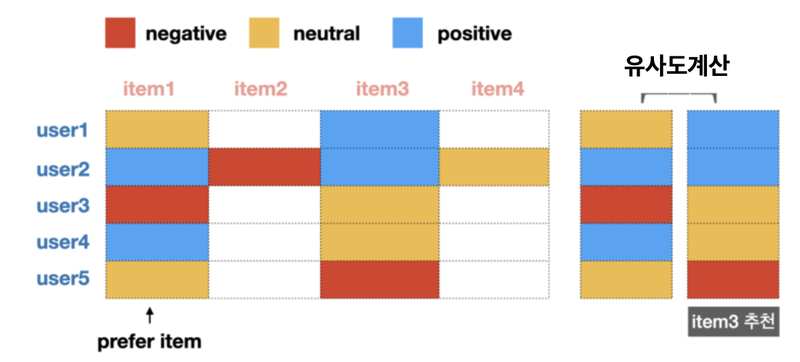

In [22]:
from IPython.display import Image, display

# 이미지 파일 경로
image_path = "/aiffel/aiffel/movie_recommendation/item3.max-800x600.png"

# 이미지를 노트북에서 표시 
display(Image(filename=image_path))

사용자 기반과 아이템 기반을 요약하면 다음과 같습니다.

사용자 기반: 당신과 비슷한 고객들이 다음 상품을 구매했습니다.
아이템 기반: 이 상품을 선택한 다른 고객들은 다음 상품을 구매했습니다.

협업 필터링 (2) 행렬 인수분해
잠재요인 협업 필터링은 평점행렬을 행렬 인수분해(matrix factorization)를 통해 잠재요인(latent factor)을 분석합니다. 일단 행렬 인수분해가 처음이신 분들도 있을테니 행렬 인수분해에 대해 잠깐 살펴보겠습니다.
행렬 인수분해에는 다음과 같은 기법들이 있습니다.

SVD(Singular Vector Decomposition)
ALS(Alternating Least Squares)
NMF(Non-negative Matrix Factorization)

행렬 인수분해는 인수분해와 비슷하다고 볼 수 있습니다. 
30을 인수분해하면 30 = 6X5 = 3X10 = 1X30 이런 식으로 곱하기로 나타낼 수 있겠죠? 
행렬도 이렇게 곱으로 분해 할 수 있으며, 분해 행렬을 사용하면 원하는 답을 더 쉽게 찾을 수 있습니다. 
(나중에 이야기 하겠지만, 추천 알고리즘에서 파라미터 수가 줄어 듭니다!)

SVD(Singular Vector Decomposition) 
SVD는 우리나라 말로 하면 특잇값 분해 입니다.
쉽게 이야기 하면, M X N 형태의 행렬 A을 다음과 같은 형태로 분해하여 나타내는 것입니다.

Q. SVD를 사용하는 이유가 뭐라고 설명하고 있나요?

"정보 복원"을 위해 사용됩니다.  
특이값 분해는 분해되는 과정보다는 분해된 행렬을 다시 조합하는 과정에서 그 응용력이 빛을 발한다. 
기존의 U,Σ,VTU,Σ,VT로 분해되어 있던 AA행렬을 특이값 p개만을 이용해 A’라는 행렬로‘부분 복원’할 수 있다. 위에서 말했던 것 특이값의 크기에 따라 A의 정보량이 결정되기 때문에 값이 큰 몇 개의 특이값들을 가지고도 충분히 유용한 정보를 유지할 수 있다. (중략)  최대한 중요한 정보들만 부분 복원해서 사용하면 사진의 용량은 줄어들지만 여전히 사진이 보여주고자 하는 내용은 살릴 수 있을 것이다.

SVD 실습
SVD는 NumPy에 이미 구현되어 있습니다. 구현하기 전에 아래 스펙을 한번 확인해 보세요.
numpy.linalg.svd

Q. svd의 return값은 각각 무엇입니까? (array) u, (array) s, (array) vh

이제 직접 이 함수를 써봅시다.
numpy.linalg의 svd 모듈을 import한 후, 4 X 4형태의 행렬 A를 SVD해보도록 하겠습니다.

In [23]:
import numpy as np
from numpy.linalg import svd

In [24]:
np.random.seed(30)
A = np.random.randint(0, 100, size=(4, 4))
A

array([[37, 37, 45, 45],
       [12, 23,  2, 53],
       [17, 46,  3, 41],
       [ 7, 65, 49, 45]])

In [25]:
svd(A)

(array([[-0.54937068, -0.2803037 , -0.76767503, -0.1740596 ],
        [-0.3581157 ,  0.69569442, -0.13554741,  0.60777407],
        [-0.41727183,  0.47142296,  0.28991733, -0.72082768],
        [-0.6291496 , -0.46389601,  0.55520257,  0.28411509]]),
 array([142.88131188,  39.87683209,  28.97701433,  14.97002405]),
 array([[-0.25280963, -0.62046326, -0.4025583 , -0.6237463 ],
        [ 0.06881225, -0.07117038, -0.8159854 ,  0.56953268],
        [-0.73215039,  0.61782756, -0.23266002, -0.16767299],
        [-0.62873522, -0.47775436,  0.34348792,  0.50838848]]))

결과값으로 행렬 U와 행렬 Σ, 행렬 V의 전치행렬이 생성됩니다. 
우리는 이 값들을 unpacking해서 각각 변수명에 할당해 줍니다. 각 행렬들을 확인해 봅시다.

In [26]:
U, Sigma, VT = svd(A)

print('U matrix: {}\n'.format(U.shape),U)
print('Sigma: {}\n'.format(Sigma.shape),Sigma)
print('V Transpose matrix: {}\n'.format(VT.shape),VT)

U matrix: (4, 4)
 [[-0.54937068 -0.2803037  -0.76767503 -0.1740596 ]
 [-0.3581157   0.69569442 -0.13554741  0.60777407]
 [-0.41727183  0.47142296  0.28991733 -0.72082768]
 [-0.6291496  -0.46389601  0.55520257  0.28411509]]
Sigma: (4,)
 [142.88131188  39.87683209  28.97701433  14.97002405]
V Transpose matrix: (4, 4)
 [[-0.25280963 -0.62046326 -0.4025583  -0.6237463 ]
 [ 0.06881225 -0.07117038 -0.8159854   0.56953268]
 [-0.73215039  0.61782756 -0.23266002 -0.16767299]
 [-0.62873522 -0.47775436  0.34348792  0.50838848]]


잘 분해가 되었군요. 이제 다시 복원해 보겠습니다. 복원을 위해서는 U, Σ, VT를 내적합니다. 한 가지 유의할 사항은 Σ는 1차원 이므로 0을 포함한 대각 행렬로 변환한 뒤 내적을 해주어야합니다.

In [27]:
# 복원된 A_와 원본 A가 같은지 확인해 보세요.

Truncated SVD
Sigma_mat = np.diag(Sigma)

A_ = np.dot(np.dot(U, Sigma_mat), VT)
A_

array([[37., 37., 45., 45.],
       [12., 23.,  2., 53.],
       [17., 46.,  3., 41.],
       [ 7., 65., 49., 45.]])

Truncated SVD
추천 시스템에서의 행렬 인수분해는 SVD 중에서도 Truncated SVD를 사용합니다. Truncated SVD는 SVD의 일종으로 우리말로 번역하면 잘린 SVD라고합니다. 다른 말로 LSA(Latent semantic analysis), 잠재 의미 분석 이라고 번역할 수 있습니다. Truncated SVD를 이용해 분해한 뒤 복원하면 SVD 처럼 완벽히 같은 행렬이 나오지 않습니다. 그 이유는 Truncated SVD는 차원을 축소한 다음 행렬을 분해하기 때문입니다. 사이킷런에서는 TruncatedSVD 기능을 함수로 제공해 줍니다.

sklearn.decomposition.TruncatedSVD

(3) 행렬 인수분해와 잠재요인 협업 필터링

SVD(특이값 분해)를 평가행렬에 적용하여 잠재요인을 분석하는 것을 도식화하면 아래와 같습니다.

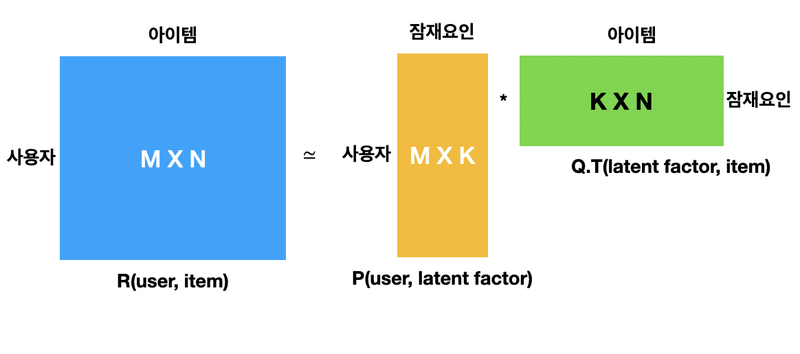

In [29]:
from IPython.display import Image, display

# 이미지 파일 경로
image_path = "/aiffel/aiffel/movie_recommendation/svd2.max-800x600.png"

# 이미지를 노트북에서 표시 
display(Image(filename=image_path))

R: 사용자와 아이템 사이의 행렬
P: 사용자와 잠재요인 사이의 행렬
Q: 아이템과 잠재요인 사이의 행렬 —> 전치 행렬 형태로 나타냄

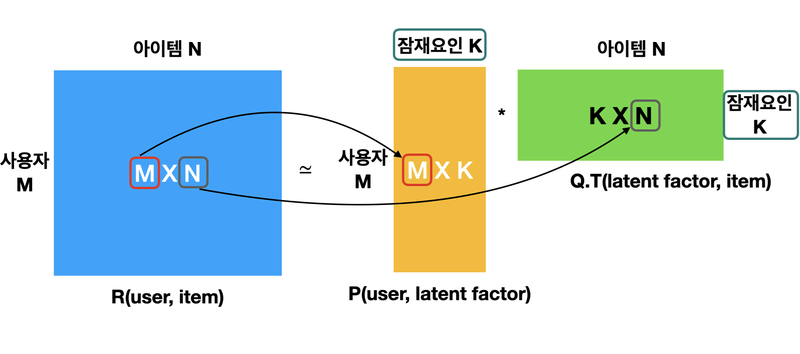

In [30]:
from IPython.display import Image, display

# 이미지 파일 경로
image_path = "/aiffel/aiffel/movie_recommendation/svd3.max-800x600.png"

# 이미지를 노트북에서 표시 
display(Image(filename=image_path))

사용자가 아이템에 대한 평점을 매기는 요인으로 많은 항목들이 있을 겁니다.
"배우가 마음에 들어서, 감독이 좋아서, 좋아하는 장르나 분위기, 마침 그날 영화 가격이 매우 싸서" 등 
평점을 매기는 것은 지극히 주관적입니다. 사람의 마음은 알 수가 없어요~
그래서 사용자가 평점을 매기는 요인을 그냥 "잠재요인"으로 취급한 뒤 그걸 SVD기법을 이용해 분해한 뒤 다시 합치는 방법으로 영화에 평점을 매긴 이유를 벡터화하여 이를 기반으로 추천합니다. 이 기법은 넷플릭스나 왓챠, 유튜브 같은 대 기업에서 사용하여 그 효과를 입증해 내었고 이후 많은 기업들이 이 기법을 채택하여 사용하고 있습니다.

Q. 잠재요인을 고려해 행렬을 인수분해하면 파라미터 수는 어떻게 변하나요? 감소한다.

이렇듯 협업 필터링을 이용하면 사용자가 아이템에 대해 평점을 매긴 평점행렬을 행렬 인수분해(Matrix Factorization)를 통해 잠재요인을 분석한 뒤 유사도를 계산할 수도 있고 사용자의 평점도 예측할 수 있습니다.

실제 추천 시스템
이상으로 추천 시스템의 기본에 대해 살펴 보았는데요. 실제로 YouTube나 Netflix 같은 대형 기업에서는 추천에 더 많은 것들을 고려합니다.
사용자의 구매 여부와 평점 데이터 뿐만 아니라 얼마나 오랜 시간 동안 시청(혹은 해당 웹 사이트에 머물렀는지), 어떤 사이트에서 유입이 되었는지, 그리고 시청한 뒤 구매로 이어지기까지의 시간 등 우리의 족적들을 다 분석합니다. 이를 전문 용어로 Digital Footprint(디지털 발자국), Digital Shadow(디지털 그림자)라고 해요.
그리고 이중에서 가장 중요한 지표가 바로 클릭률 입니다. 전문 용어로는 CTR(Click Through Rate) 입니다. CTR은 마케팅에서도 중요한 지표로 작용하는 용어이기도합니다.

참고: 클릭률 그리고 추천 시스템, 기술과 가치의 조화

이러한 데이터들을 모아 추천을 한 뒤, 해당 아이템이 적절한 추천인지 여부를 평가하는 것 역시 중요한 일입니다. 추천한 제품이 구매로 이어졌는지를 통해 추천에 성공했는지를 평가하기도 하고 모델 단계에서 평가하기도 합니다.
이처럼, 추천 시스템은 굉장히 큰 시스템입니다. 데이터를 기반으로 사용자에게 적절한 제품을 추천한다는 것 그리고 그것이 구매로 이어지는것은 매출과 직결되는 문제이기도 합니다. 좋은 추천 시스템을 만들기 위해서는 어떤 데이터를 쓸지 많은 고민이 필요합니다. 사용자와 연관성이 있고, 구매와 직결되는 각종 데이터를 수집하고 정렬(sorting)하여 다시 순위(ranking)를 매긴 다음 평가하는 작업을 반복해가며 적합한 데이터와 추천 시스템을 만들어냅니다.

추천 시스템에 머신러닝이 적용될 수도 있는 것이지 머신러닝 안에 추천 시스템이 있는 것은 결코 아닙니다.
